In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from idlescape import *
try:
    from ipywidgets import interact, widgets
except ImportError:
    %pip install ipywidgets
    from ipywidgets import interact, widgets

locationFile = "data/locations.json"
itemFile = "data/items.json"
player = Character(
    datafile=itemFile,
    fishing_level=90,
    fishing_bonus=60,
    fishing_set_bonus=0.25,
    bait_power=55.5,
    reel_power=47+15,
    bonus_rarity=30,
    mining_level=86,
    mining_set_bonus=0.25,
    mining_bonus=59,
    foraging_level=82,
    foraging_bonus=59,
    foraging_set_bonus=0.25,
    )
fishing = Fishing(player, locationFile);
mining = Mining(player, locationFile);
foraging = Foraging(player, locationFile);

player.enchantments['gathering'] = 5
player.enchantments['nature'] = 3
player.enchantments['herbalist'] = 3
player.enchantments['seedHarvesting'] = 3

In [2]:
class InteractiveCharacter:
    def __init__(self, item_file, location_file, **kwargs):
        self.player_stats = kwargs.get("player_stats", dict())
        self.player = Character(datafile=item_file, *(self.player_stats))
        self.mining = Mining(self.player, location_file)
        self.foraging = Foraging(self.player, location_file)
        self.fishing = Fishing(self.player, location_file)
        
    def setup_display(self):
        interact(lambda x: setattr( self.player, 'fishing_level', x ), 
                 x=widgets.IntSlider(min=1, max=200, value=self.player.fishing_level, description='Fishing Level'))
        interact(lambda x: setattr( self.player, 'mining_level', x ), 
                 x=widgets.IntSlider(min=1, max=200, value=self.player.mining_level, description='Mining Level'))
        interact(lambda x: setattr( self.player, 'foraging_level', x ), 
                 x=widgets.IntSlider(min=1, max=200, value=self.player.foraging_level, description='Foraging Level'))
        
Chikenz = InteractiveCharacter(itemFile, locationFile)
Chikenz.setup_display()

interactive(children=(IntSlider(value=1, description='Fishing Level', max=200, min=1), Output()), _dom_classes…

interactive(children=(IntSlider(value=1, description='Mining Level', max=200, min=1), Output()), _dom_classes=…

interactive(children=(IntSlider(value=1, description='Foraging Level', max=200, min=1), Output()), _dom_classe…

In [115]:
def zone_summary(action, zone):
    item_series = action.location_item_histogram(zone, interval='hour').round(1)
    fig_size = (16, 6)
    if( item_series.sum() > 0 ):
        fig, axs = plt.subplots(1,2, figsize=(16,6))
        axs[0].set_title(zone)
        item_series[item_series.gt(0)].plot.pie(ax=axs[0])
        ax = item_series.plot.bar(ax=axs[1])
        ax.grid(axis='y')
        axs[1].bar_label(axs[1].containers[0])
    return item_series
        
def action_summary(action, **kwargs):
    series_list = []
    indices = action.list_of_actions()
    for action_name in indices:
        series_list.append(zone_summary(action, action_name))
    df = pd.DataFrame(series_list, index=indices).fillna(0)
    return df

craft_xp = {"Log": 5, "Oak Log": 10, "Willow Log": 15, "Maple Log": 30, "Yew Log": 45, "Elder Log": 100, 
            "Raw Tentacle Meat": 150, "Rotten Driftwood": 30, "Sturdy Driftwood": 70,
            "Aqueous Grass": 1, "Water Weeds": 3, "River Vines": 6, "Violet Ribbons": 9, "White Reeds": 16, "Ancient Kelp": 20,
            "Stygian Ore": 10}
# Fish oil
for (k, v) in player.item_data.items():
    if "fish" in v.get("tags",[]):
        crafting_xp = 50 * v.get("size",0)/20
        craft_xp[v["name"]] = crafting_xp

def craft_summary(from_action_summary):
    sub_series = []
    for (k, v) in craft_xp.items():
        if k in from_action_summary:
            sub_series.append( (from_action_summary[k] * v ) )
    return pd.concat(sub_series, axis=1).sum(1)
#z = action_summary(Chikenz.mining)

Grasslands         4722.0
Verdant Valley     5704.0
Fungal Grotto      4071.0
The Tangle        12288.0
Misty Marsh        9595.0
Frozen Tundra      9507.0
Haunted Woods      9936.0
Living Forest     14802.5
dtype: float64

,Carrot Seed,Honey,Carrot,Potato,Potato Seed,Wildberry,Wildberry Bush Seed,Branch,Log,Glowbug Bait,...,Snow,Yew Tree Seed,Yew Log,Mandrake,Black Berry,Fairy Dust,Lotus Flower,Durian,Elder Log,Elder Tree Seed
Grasslands,69.3,47.2,45.4,45.4,58.4,112.0,59.4,1954.2,944.4,83.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Verdant Valley,31.2,141.6,25.1,0.0,0.0,0.0,0.0,1192.5,394.2,58.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fungal Grotto,67.0,0.0,185.8,185.8,67.0,0.0,0.0,334.2,135.7,31.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Tangle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.8,204.8,8.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Misty Marsh,0.0,0.0,0.0,42.3,47.6,0.0,0.0,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frozen Tundra,0.0,0.0,0.0,0.0,0.0,105.6,26.4,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Haunted Woods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.3,73.6,43.7,43.7,43.7,0.0,0.0,0.0,0.0
Living Forest,0.0,25.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.9,72.8,0.0,0.0,48.5,48.5,48.5,44.9,1.0


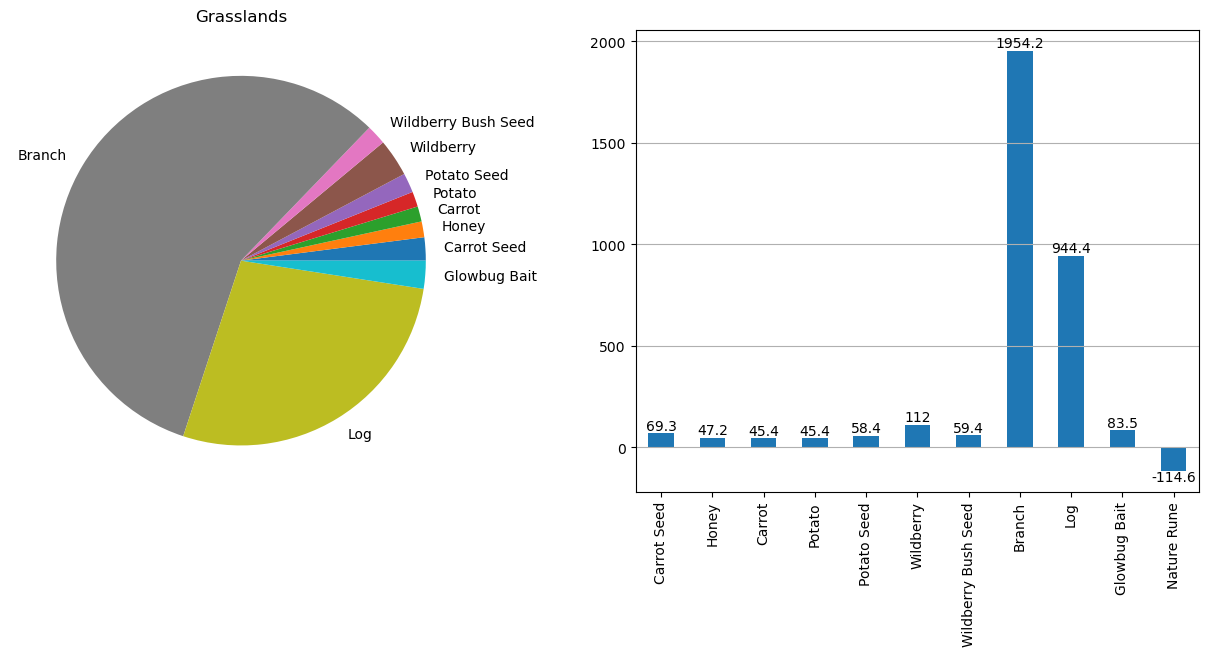

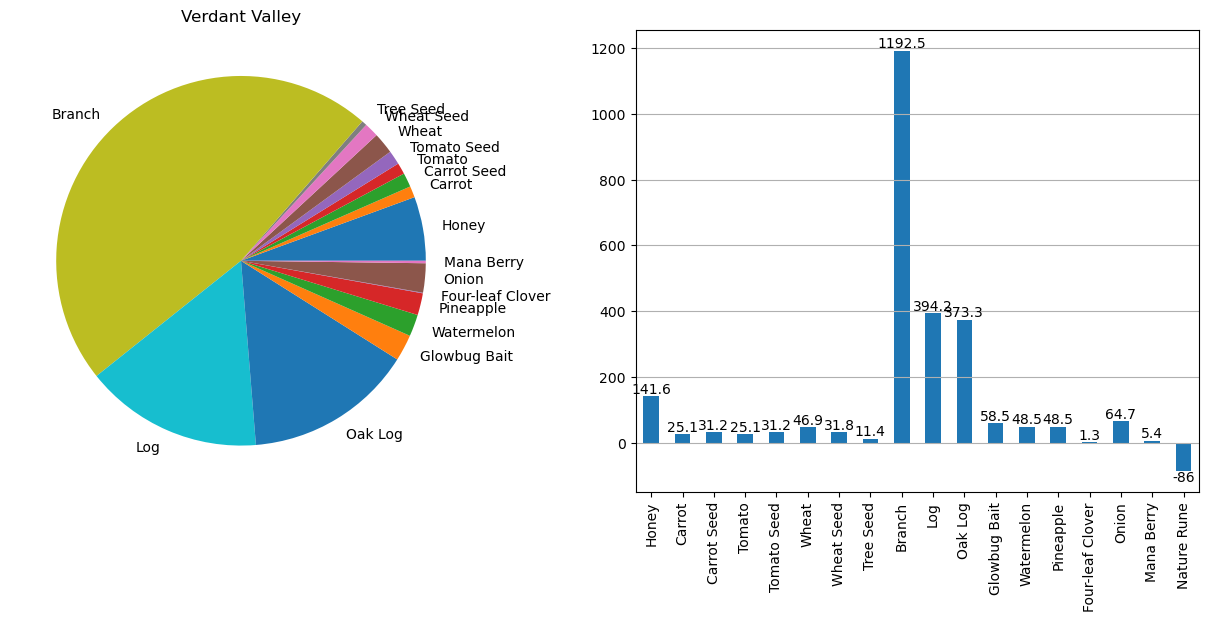

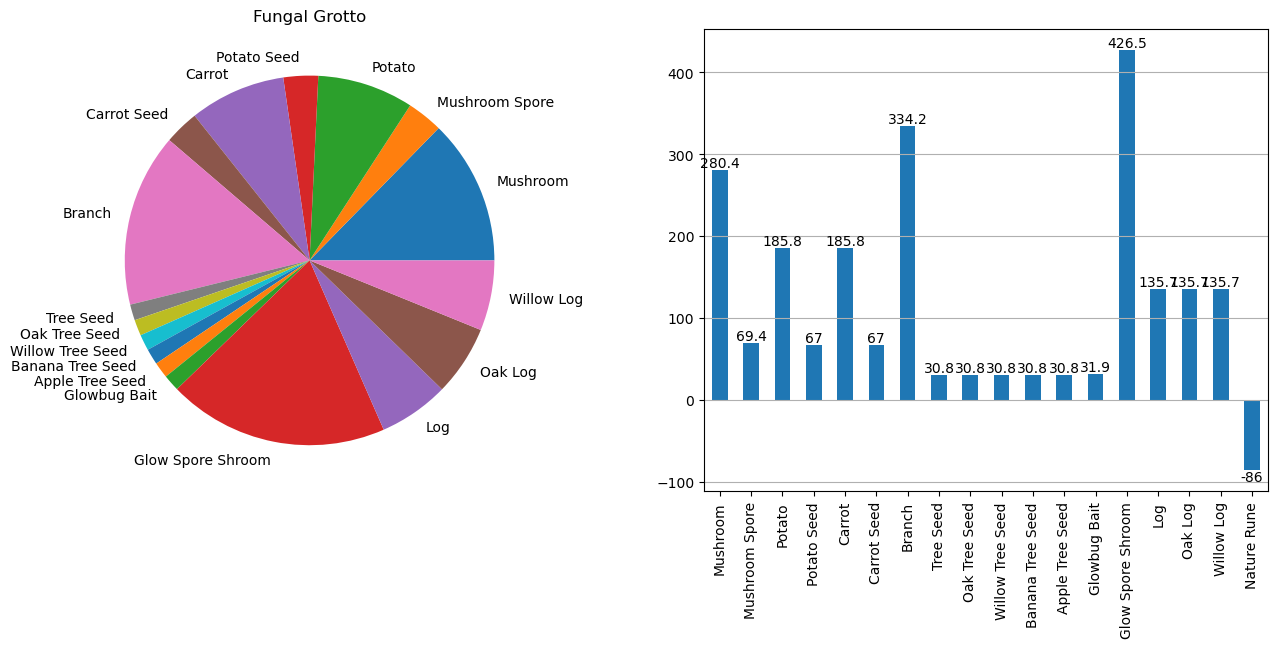

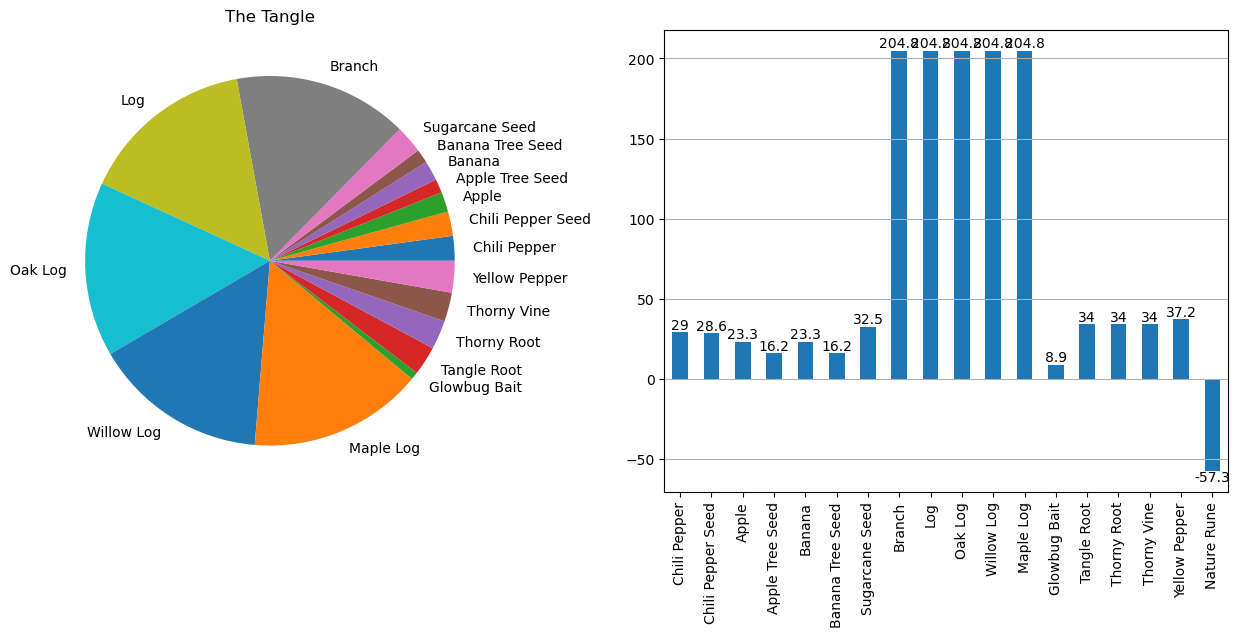

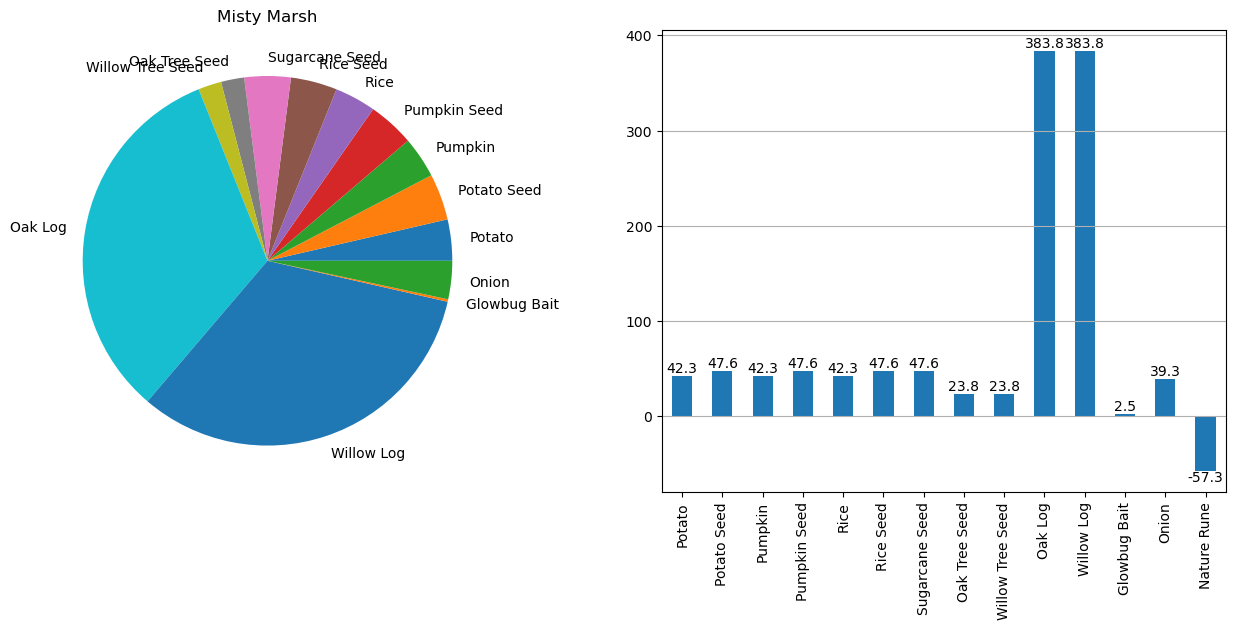

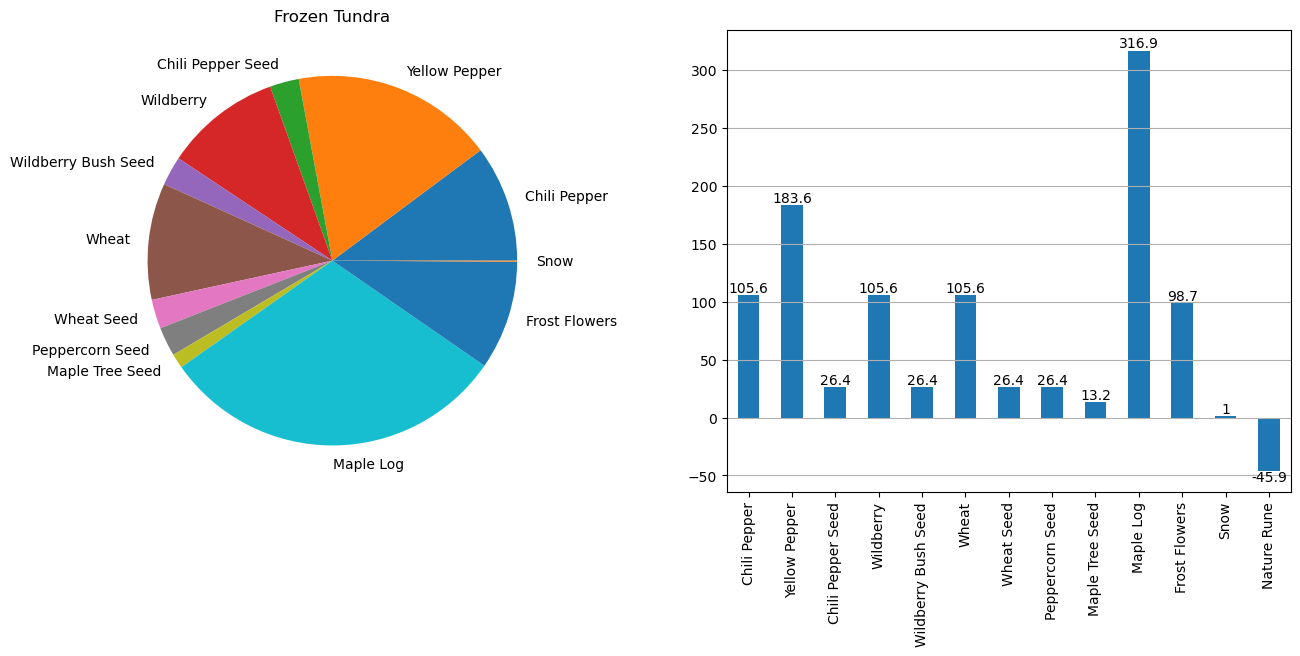

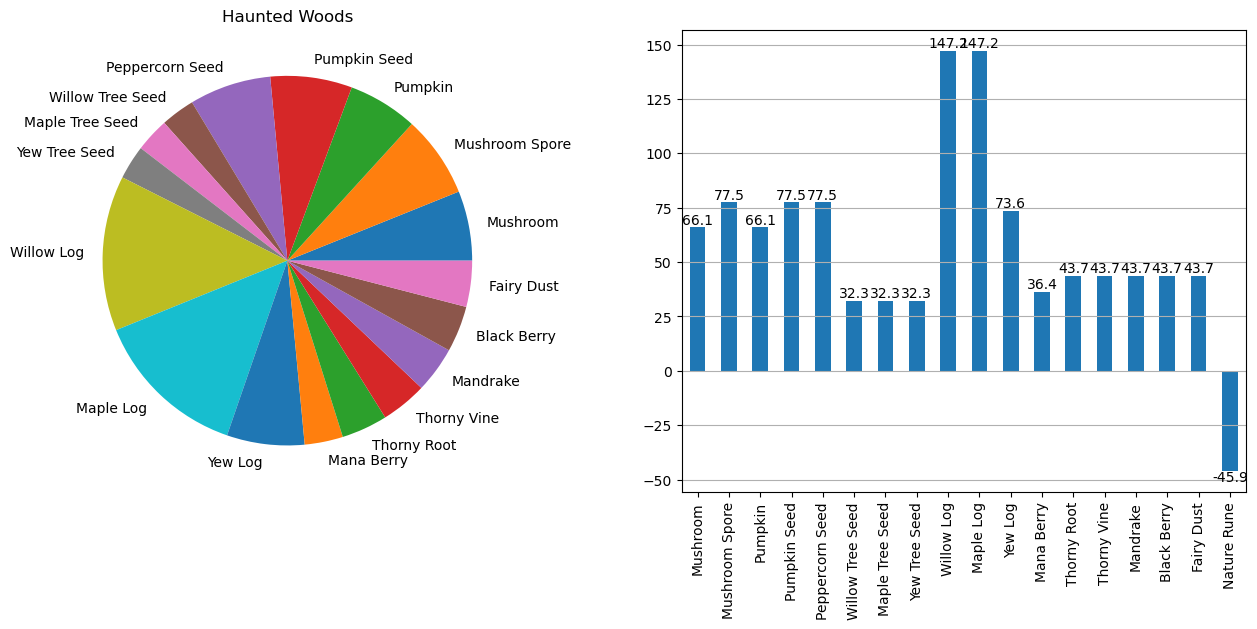

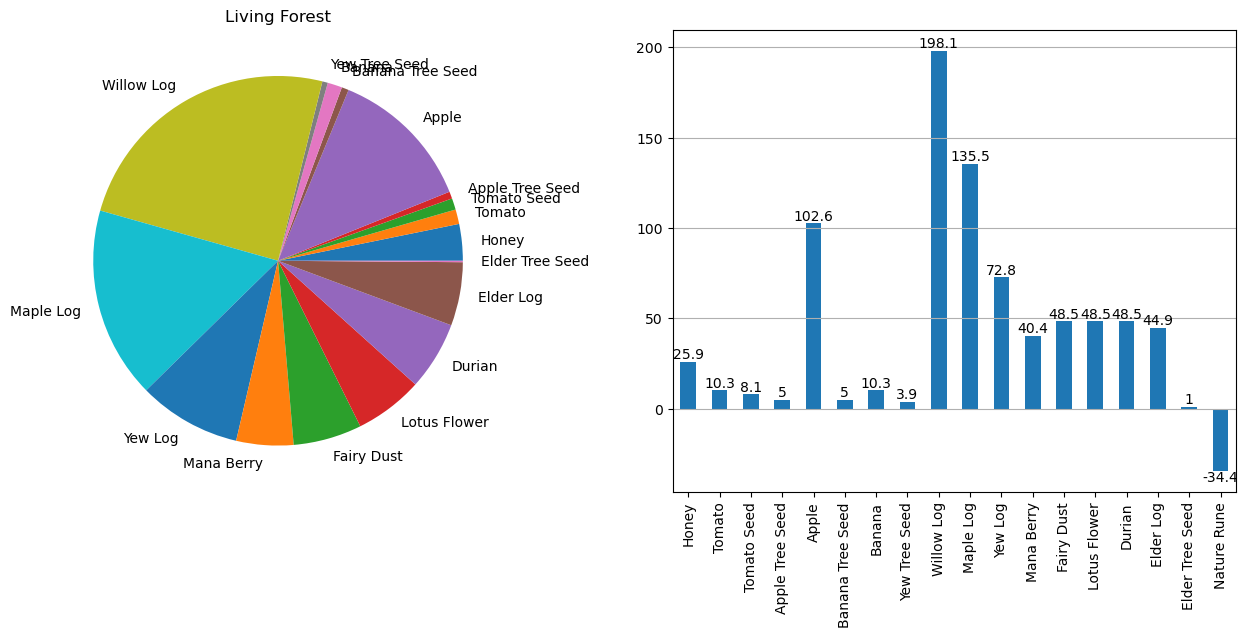

In [116]:
forage = action_summary(foraging)
display(craft_summary(forage))
display(forage)

Shallow Pond     4497.60
Lazy River       7631.10
Still Lake       7364.35
Open Ocean      11346.55
Stormy Seas     14352.75
dtype: float64

,Raw Shrimp,Raw Anchovy,Raw Magnetic Minnow,Seaweed,Aqueous Grass,Rotten Driftwood,Water Weeds,Nature Rune,Raw Trout,Raw Salmon,...,Raw Tuna,Raw Shark,Raw Hammerhead Shark,Raw Great White Shark,Raw Huge Tuna,Raw Megalodon,Raw Tentacle Meat,Mystical Driftwood,White Reeds,Ancient Kelp
Shallow Pond,482.5,316.7,53.4,102.3,112.8,71.0,41.1,-53.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lazy River,0.0,0.0,54.7,45.8,79.1,55.8,112.4,-47.5,317.2,282.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Still Lake,0.0,0.0,33.0,34.3,64.6,16.5,60.4,-42.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Open Ocean,0.0,0.0,0.0,43.2,42.7,46.3,42.7,-38.9,0.0,0.0,...,253.4,172.9,77.7,31.8,10.2,2.8,0.0,5.1,15.6,0.0
Stormy Seas,0.0,0.0,0.0,66.6,35.7,63.6,35.7,-38.3,0.0,0.0,...,141.8,144.1,86.9,28.4,47.3,13.7,0.0,5.3,35.7,32.3


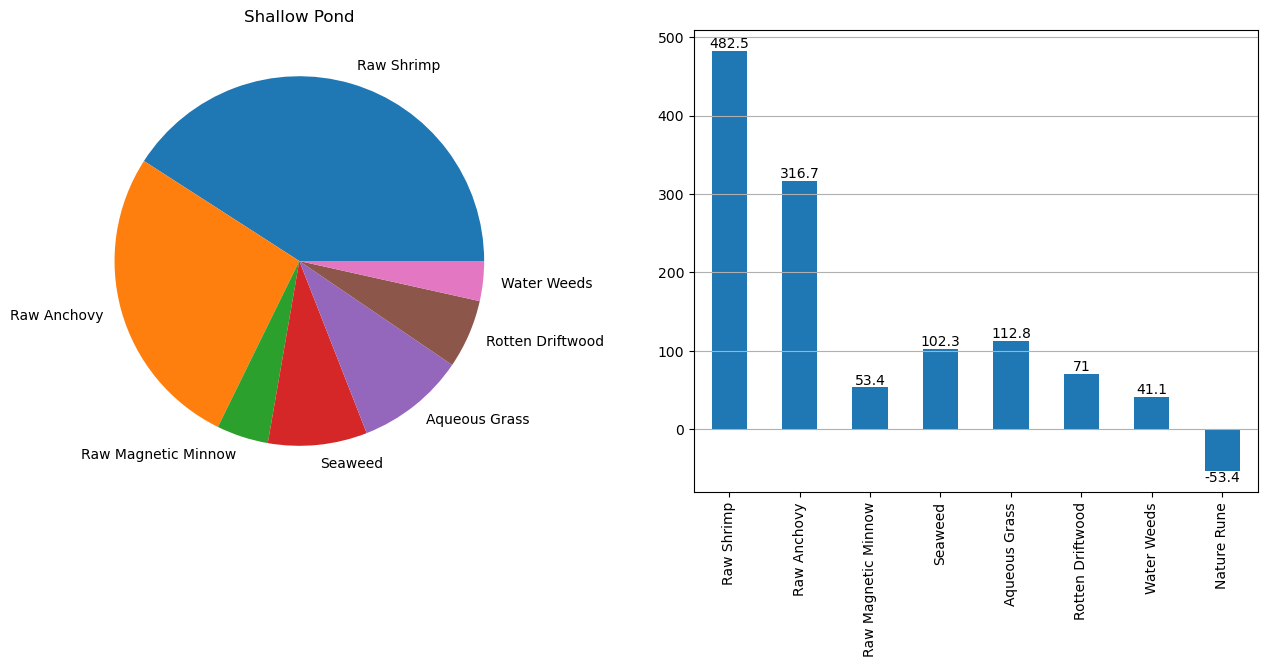

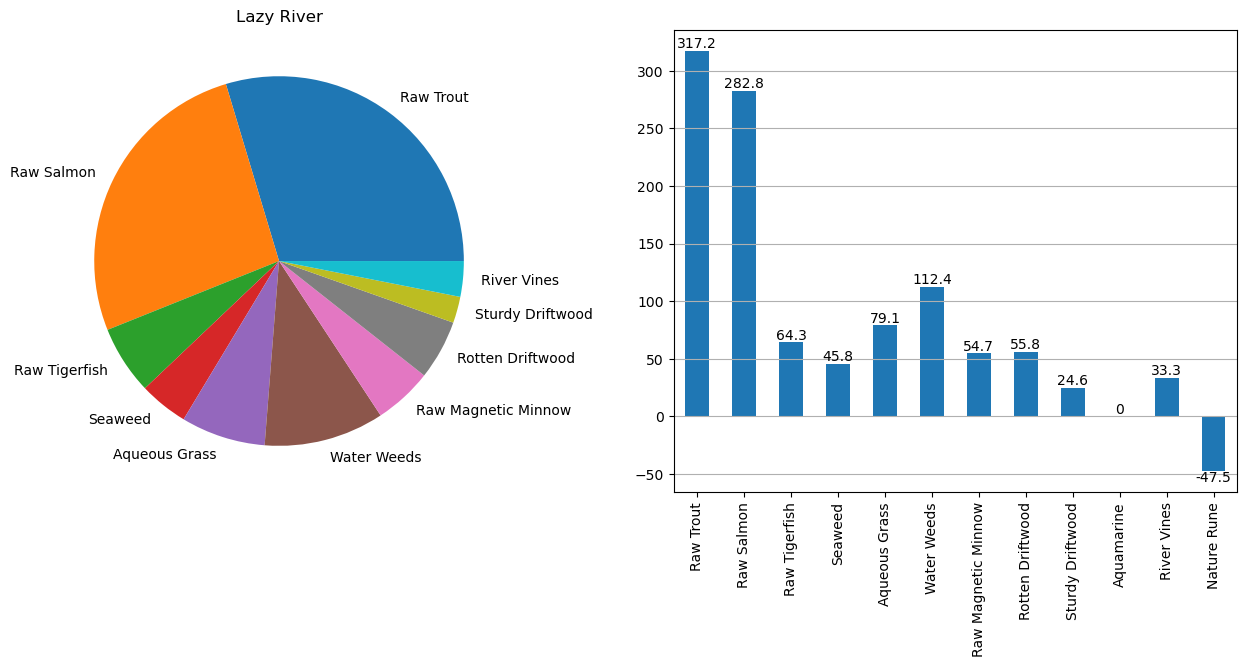

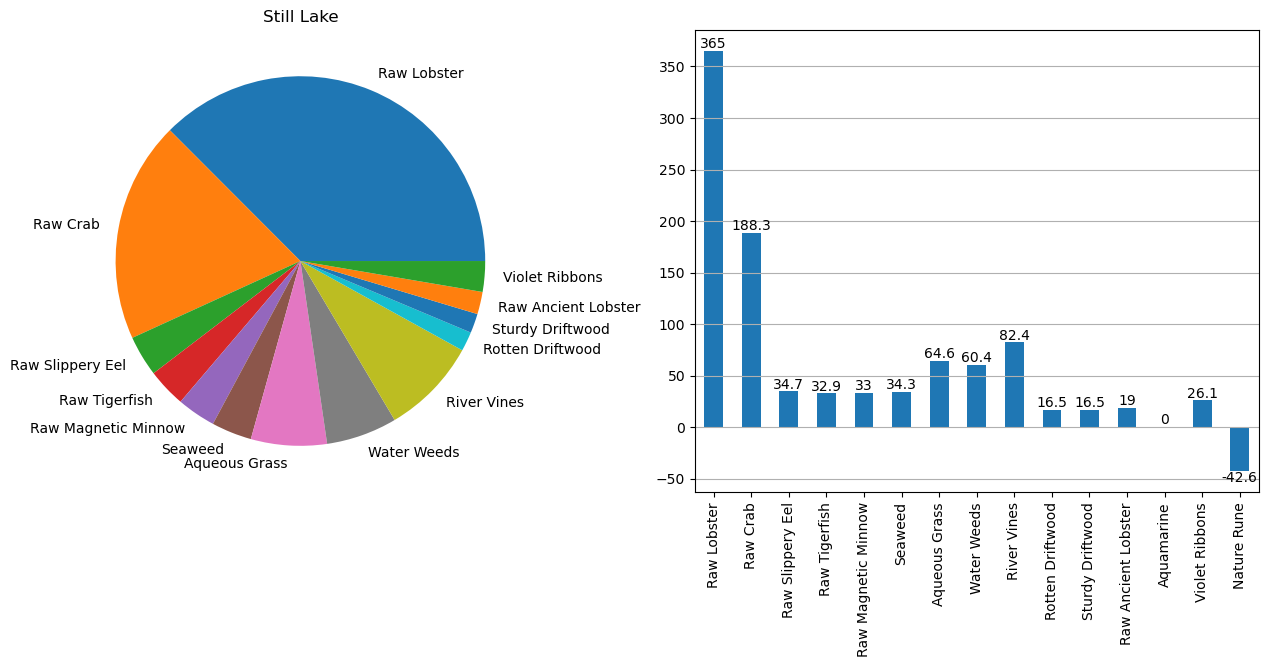

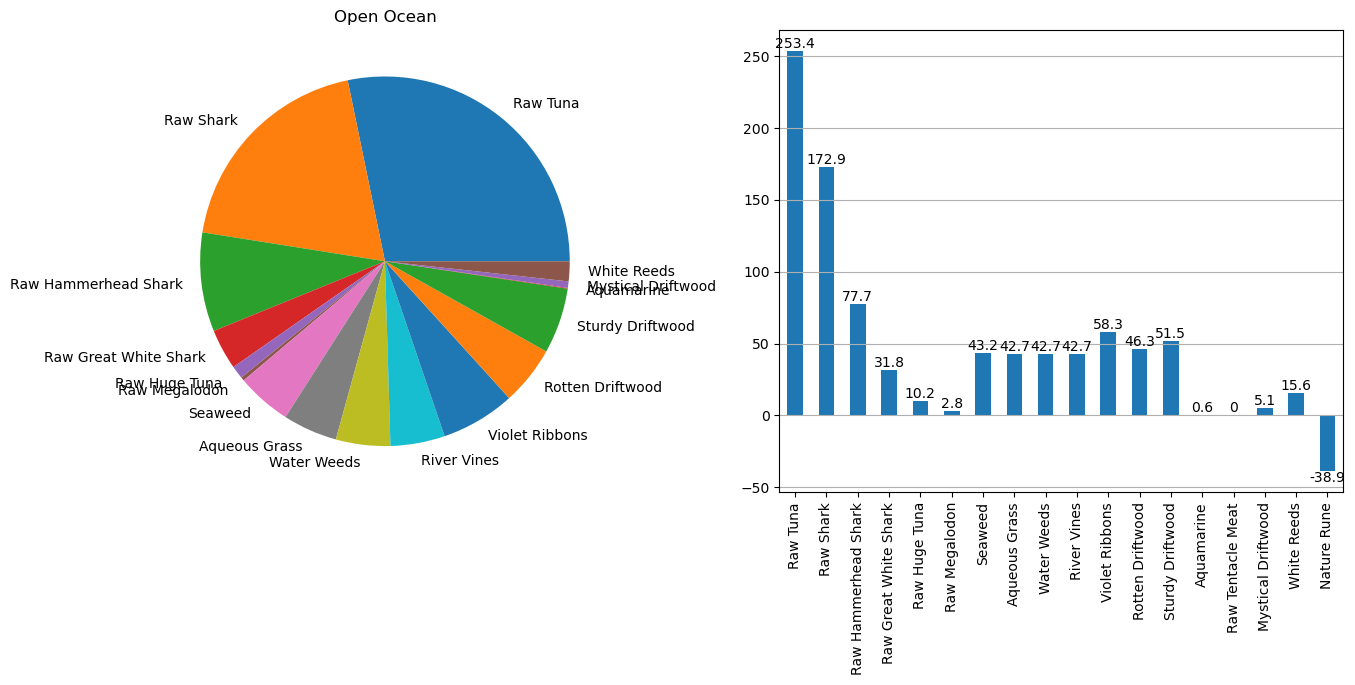

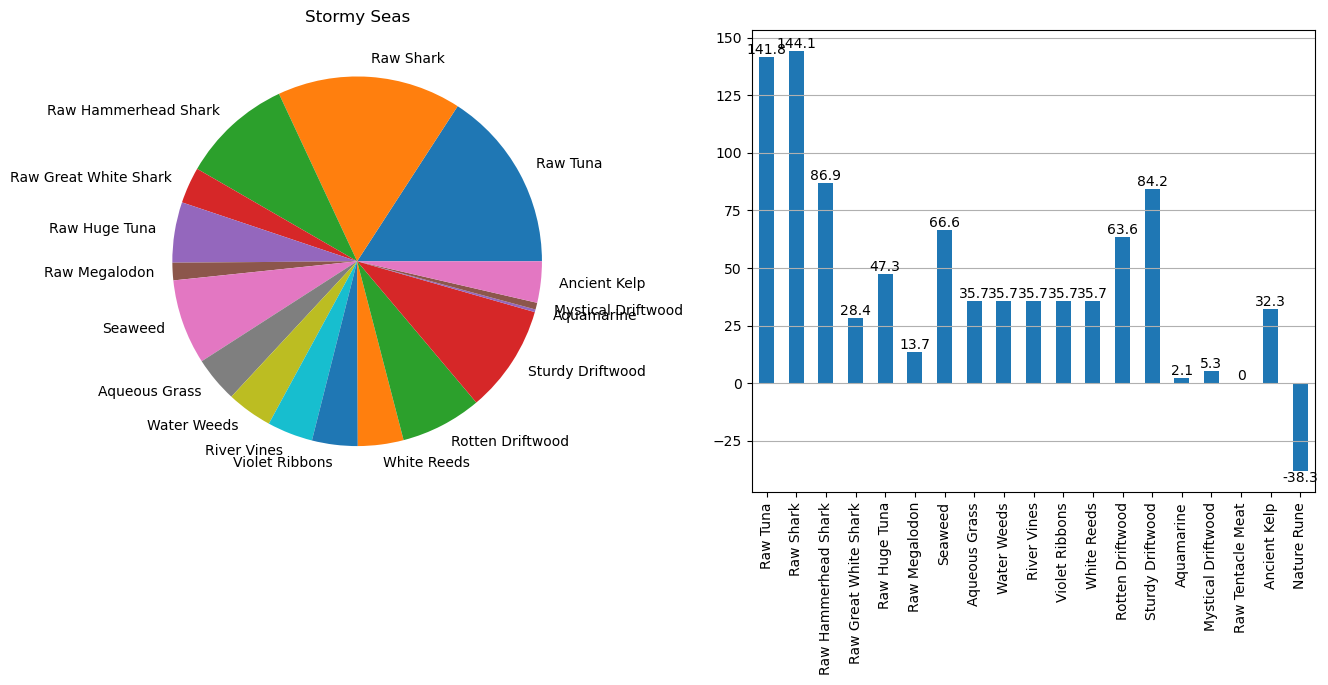

In [117]:
fishy = action_summary(fishing)
display(craft_summary(fishy))
display(fishy)

Clay Pit                  0.0
City Outskirts Mine       0.0
Village Quarry            0.0
Desert Mine               0.0
Underground Mine          0.0
Hidden Mine               0.0
Volcano Mine              0.0
Slate Spires              0.0
Deep Pit               1048.0
dtype: float64

,Clay,Copper Ore,Tin Ore,Stone,Sand,Fat Nightcrawler Bait,Nature Rune,Iron Ore,Coal,Mithril Ore,Silver,Salt,Rune Slate,Gold Ore,Adamantite Ore,Runite Ore,Stygian Ore,Void Stone
Clay Pit,1106.7,553.4,553.4,276.7,415.0,27.7,-139.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
City Outskirts Mine,345.9,518.8,518.8,345.9,345.9,17.3,-87.3,86.5,86.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Village Quarry,0.0,0.0,0.0,1080.8,0.0,17.3,-87.3,864.6,648.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Desert Mine,49.4,0.0,0.0,0.0,549.2,0.0,-58.2,98.9,109.8,219.7,219.7,109.8,98.9,54.9,0.0,0.0,0.0,0.0
Underground Mine,0.0,0.0,0.0,116.4,0.0,0.0,-58.2,58.2,58.2,349.3,145.5,232.9,174.7,203.8,0.0,0.0,0.0,0.0
Hidden Mine,0.0,0.0,0.0,139.7,0.0,0.0,-46.6,0.0,0.0,93.2,186.3,0.0,93.2,93.2,326.0,46.6,0.0,0.0
Volcano Mine,0.0,0.0,0.0,0.0,0.0,0.0,-46.6,0.0,0.0,186.3,186.3,0.0,93.2,93.2,186.3,186.3,0.0,0.0
Slate Spires,0.0,0.0,0.0,427.7,427.7,0.0,-99.8,0.0,0.0,0.0,0.0,0.0,3564.4,0.0,0.0,0.0,0.0,0.0
Deep Pit,0.0,0.0,0.0,0.0,0.0,0.0,-34.9,0.0,0.0,0.0,0.0,0.0,104.8,157.2,0.0,349.3,104.8,34.9


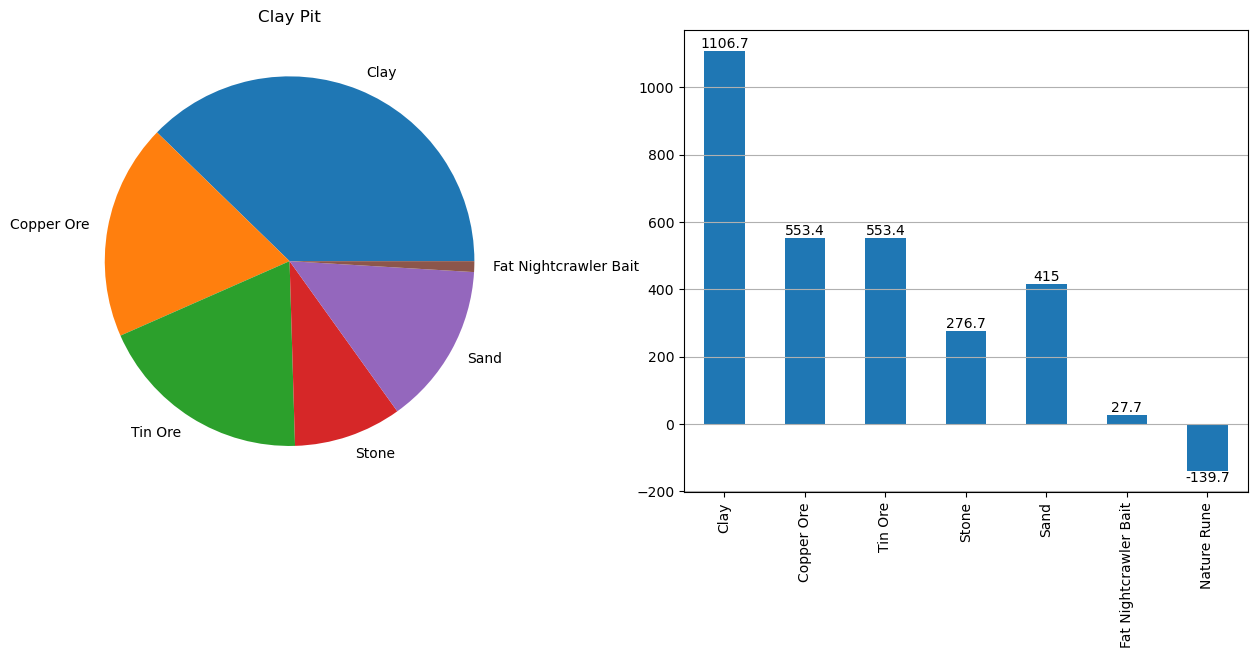

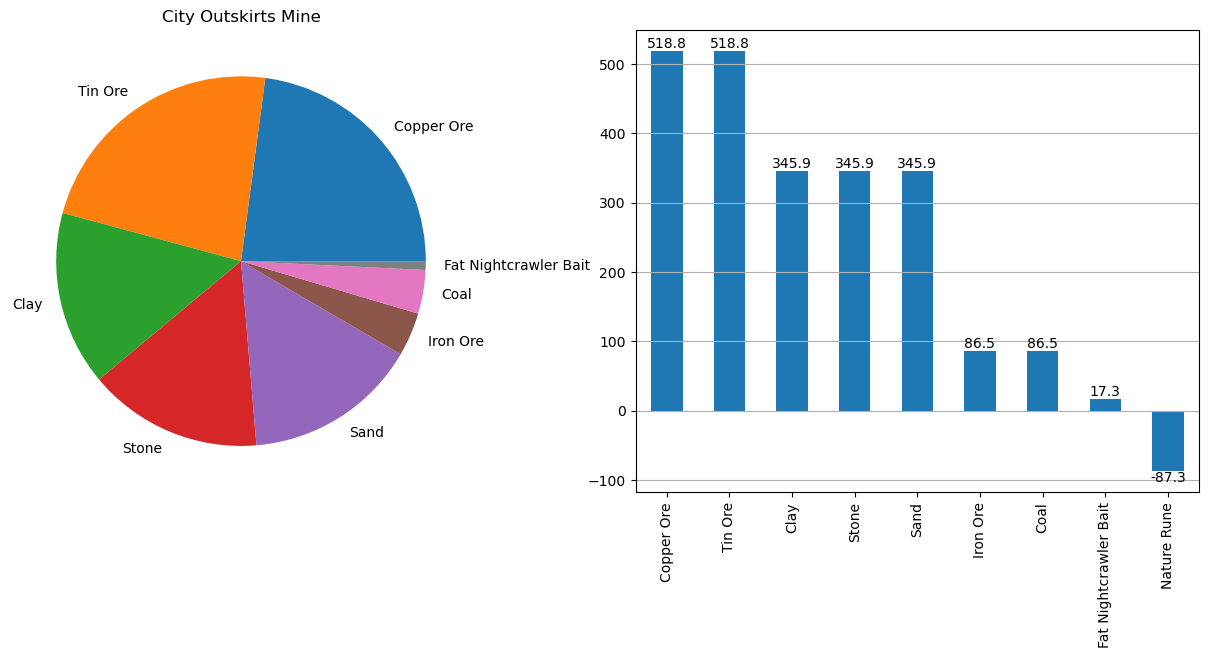

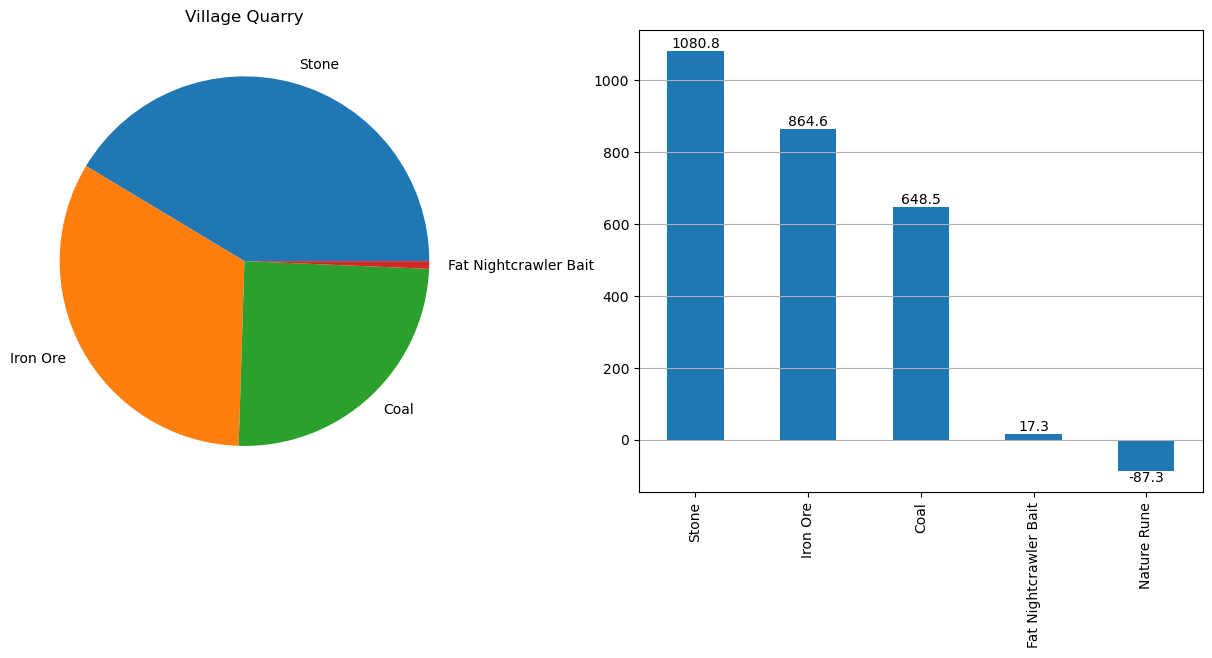

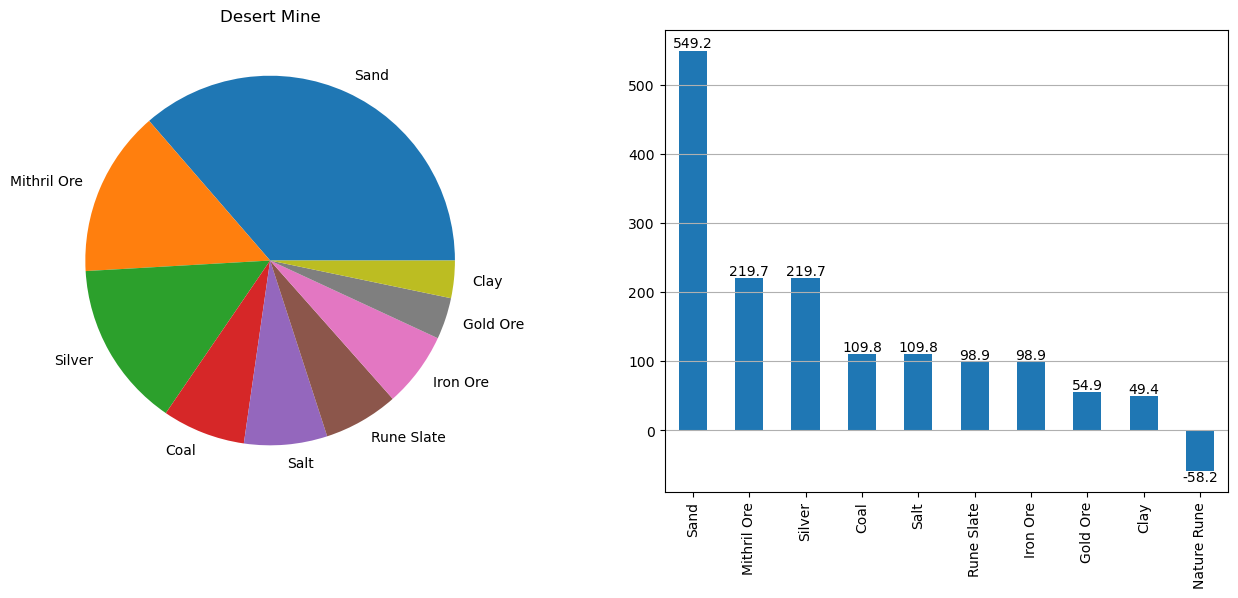

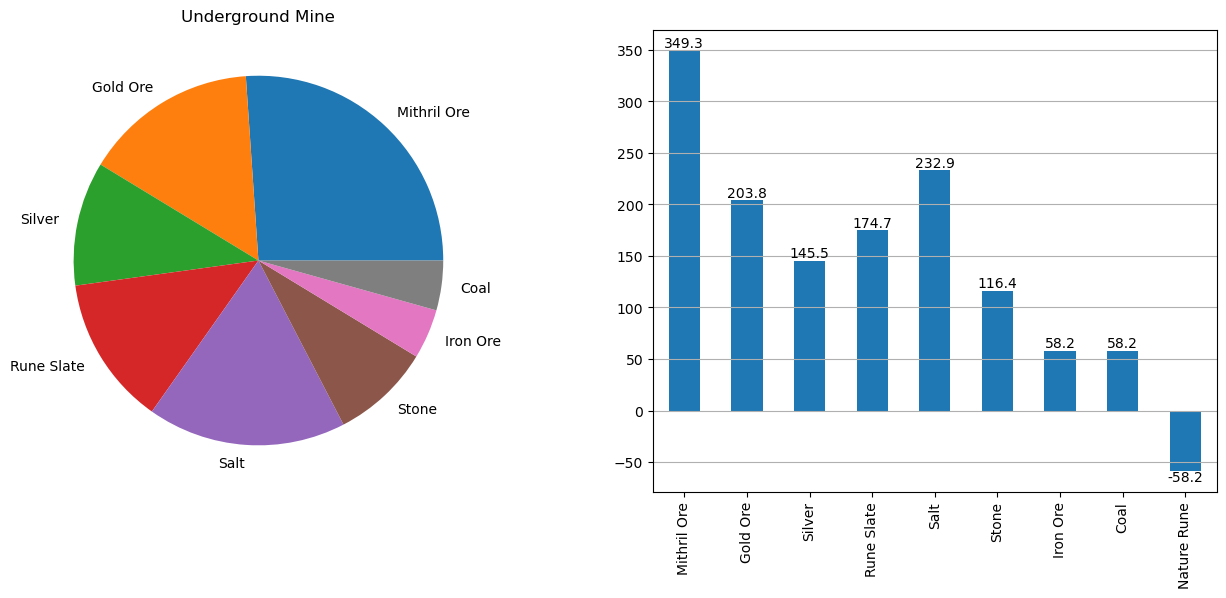

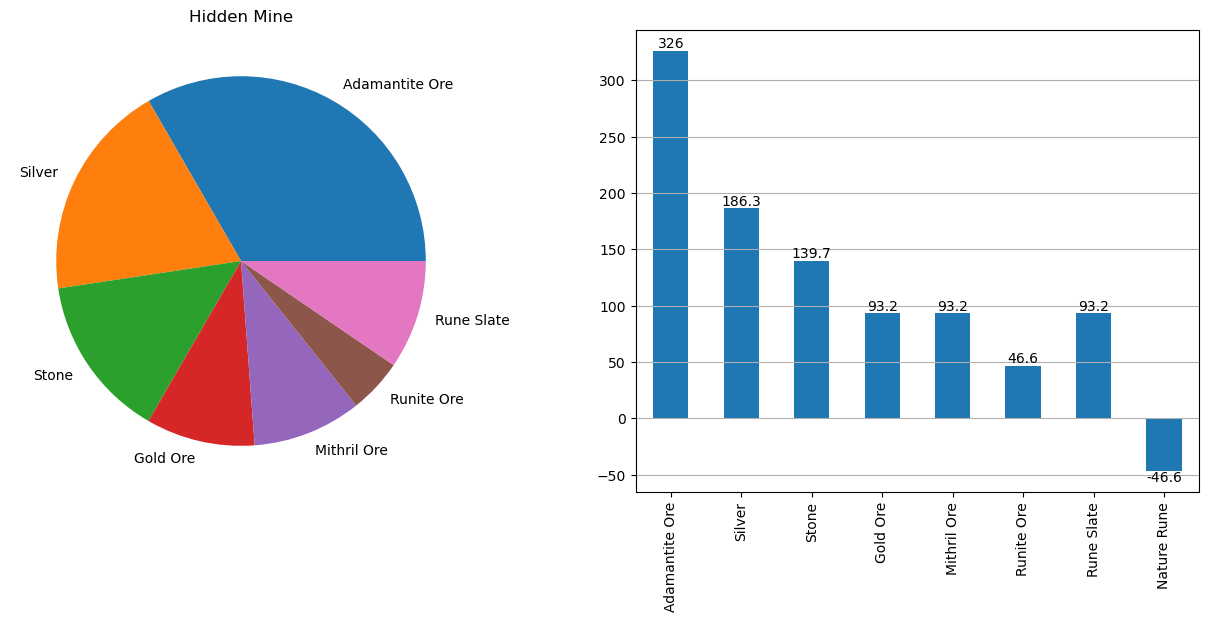

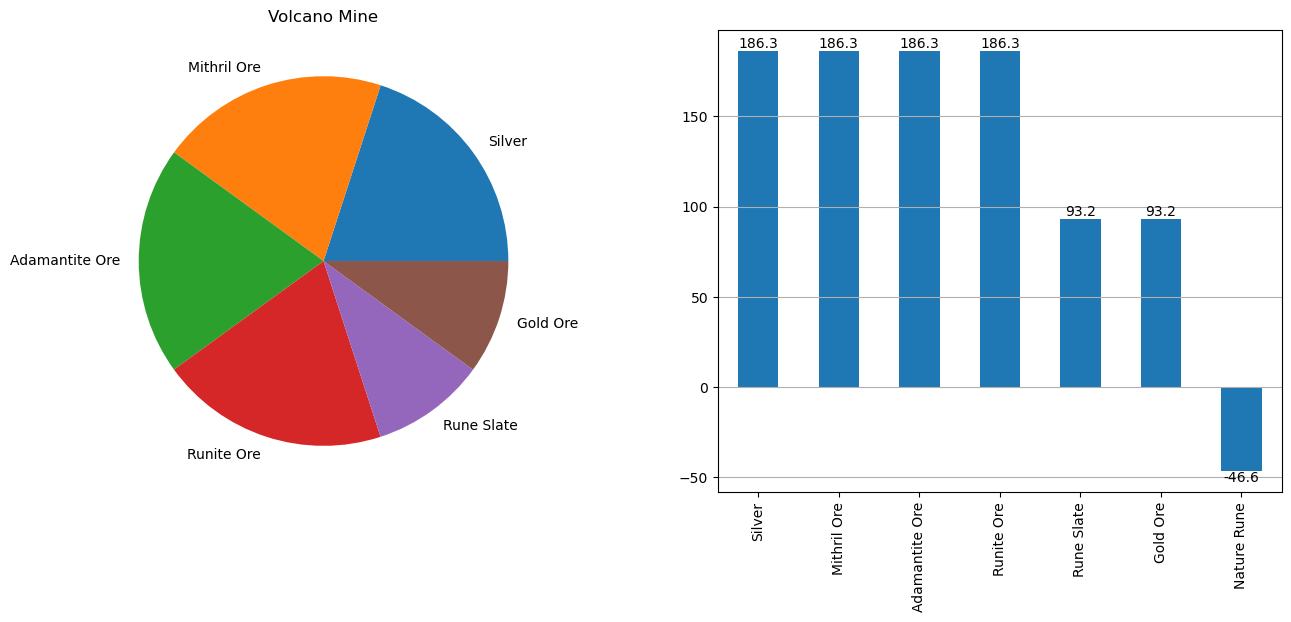

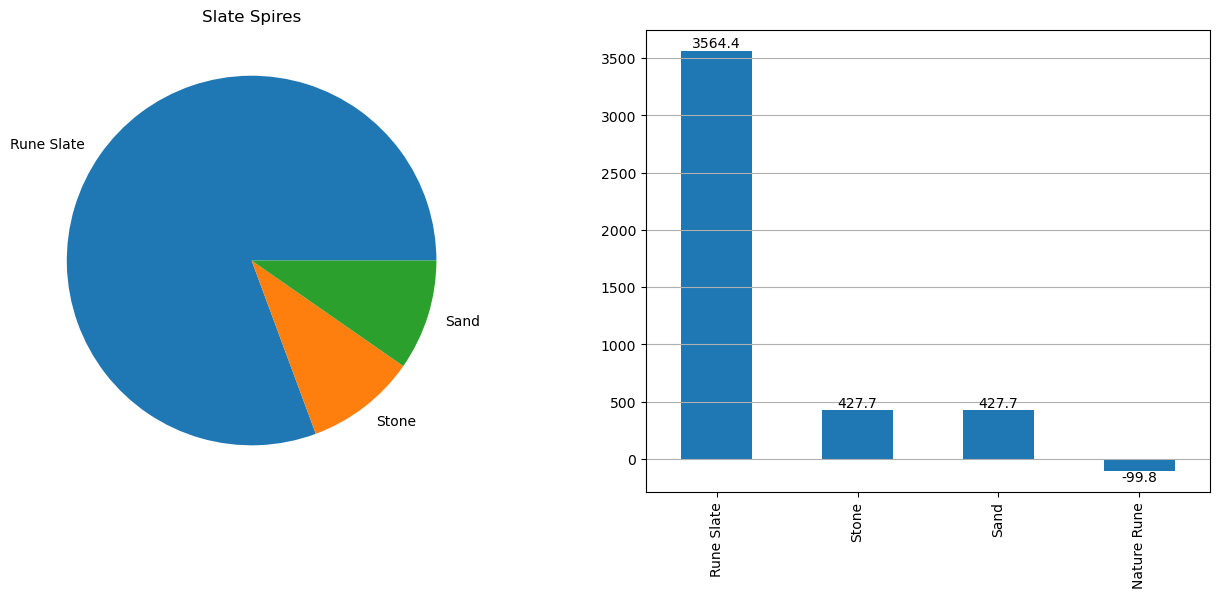

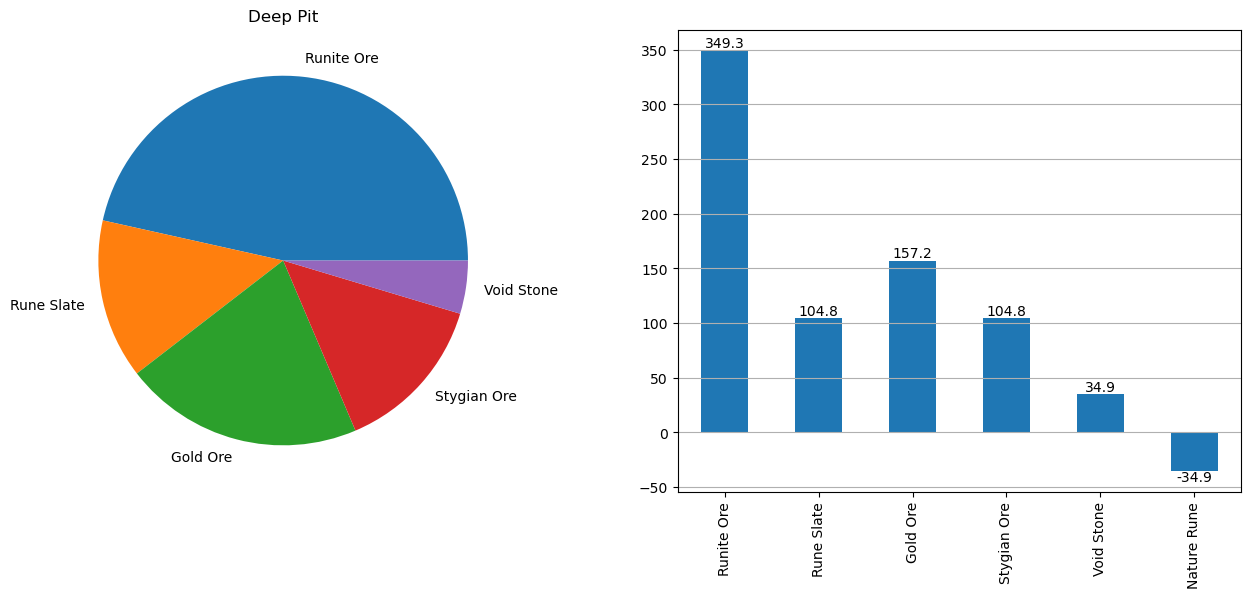

In [102]:
minno = action_summary(mining)
display(craft_summary(minno))
display(minno)